# Ocean Surface Buoyancy Forcing Analysis - Figures 4 & 5

This notebook analyzes changes in ocean surface buoyancy forcing following a large volcanic eruption and creates Figures 4 and 5 showing seasonal patterns of surface forcing anomalies.

## Scientific Context

Volcanic eruptions can affect ocean circulation through surface buoyancy forcing, which depends on:
1. **Thermal forcing**: Surface heat flux (SHF) changes from atmospheric cooling
2. **Haline forcing**: Surface freshwater flux (SFWF) changes from altered precipitation/evaporation
3. **Net effect**: Combined impact on seawater density and deep water formation

Understanding these mechanisms is crucial for explaining how volcanic eruptions trigger AMOC transitions.

## Experimental Setup

**Volcanic Experiment:**
- 500 Tg SO₄ equatorial eruption at model year 7701
- 50-member ensemble (volcanic forcing applied)
- Climate state: 230 ppm CO₂ (glacial conditions)

**Control Experiment:**
- No volcanic forcing at year 7701
- 50-member ensemble (noise-only variability)
- Same initial conditions and climate state

**Variables Analyzed:**
- **SST**: Sea Surface Temperature (°C)
- **SSS**: Sea Surface Salinity (psu)
- **SHF**: Surface Heat Flux (W/m²) - positive = ocean heat gain
- **SFWF**: Surface Freshwater Flux (cm/yr) - positive = ocean freshening

## Time Period Analysis

The analysis divides the post-eruption period into three phases:

1. **Period 1 (Years 7701-7705)**: Immediate volcanic response (0-5 years post-eruption)
2. **Period 2 (Years 7706-7715)**: Intermediate response (5-15 years post-eruption)
3. **Period 3 (Years 7716-7720)**: Later response (15-20 years post-eruption)

Each period is analyzed for:
- **Winter (DJF)**: December-January-February averages
- **Summer (JJA)**: June-July-August averages
- **Annual**: Full year averages

## Figure Structure

**Figure 4: Winter (DJF) Surface Forcing Anomalies**
- Shows volcanic minus control differences during Northern Hemisphere winter
- Critical for understanding deep water formation in North Atlantic
- 3 time periods × 4 variables = 12 panels

**Figure 5: Summer (JJA) Surface Forcing Anomalies**
- Shows volcanic minus control differences during Northern Hemisphere summer
- Reveals seasonal cycle of volcanic impact
- 3 time periods × 4 variables = 12 panels

## Key Processing Steps

1. **Ensemble Processing**: Load 50-member ensembles for volcanic and control experiments
2. **Ensemble Means**: Calculate mean response across all members
3. **Regridding**: Interpolate from POP2 tripole grid to regular lat-lon grid
4. **Seasonal Averaging**: Extract DJF and JJA months and compute yearly seasonal means
5. **Period Averaging**: Average over three defined time periods
6. **Anomaly Calculation**: Compute volcanic minus control differences
7. **Mapping**: Create geographic maps showing spatial patterns of forcing changes

## Scientific Questions

1. How does volcanic cooling affect ocean surface heat and freshwater fluxes?
2. What are the spatial patterns of buoyancy forcing changes in deep water formation regions?
3. How do forcing anomalies evolve over time following the eruption?
4. Are there important seasonal differences in the volcanic response?
5. Can these surface forcing changes explain AMOC weakening/transitions?

## Technical Details

- **Model**: CESM1.3 iCESM with POP2 ocean component
- **Resolution**: ~1° ocean grid (384×320 displaced pole grid)
- **Regridding**: Bilinear interpolation to 1°×1° regular grid
- **Ensemble Method**: Monte Carlo approach with small initial condition perturbations
- **Statistical Significance**: Ensemble spread provides uncertainty estimates

In [2]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import gridspec
import cmocean as ocm
from xclim import ensembles
import gsw
#import seawater
import xesmf as xe
import cftime
import nc_time_axis
import dask, distributed
from dask.distributed import Client


In [3]:
client = Client()
client

<Client: 'tcp://127.0.0.1:41959' processes=4 threads=12, memory=59.44 GiB>

In [4]:
import warnings
warnings.filterwarnings('ignore')
SSS_volc = ensembles.create_ensemble(glob.glob('/scratch/pproc/eq500tg7701_ens/cesmi6gat31rblc230iveq500tg7701e0??_ocn_SSS.nc'), use_cftime=True).squeeze()
SSS_novolc = ensembles.create_ensemble(glob.glob('/scratch/pproc/eq500tg7701_ens/cesmi6gat31rblc230ivnoeq500tg7701e0??_ocn_SSS.nc'), use_cftime=True).squeeze()
SST_volc = ensembles.create_ensemble(glob.glob('/scratch/pproc/eq500tg7701_ens/cesmi6gat31rblc230iveq500tg7701e0??_ocn_SST.nc'), use_cftime=True).squeeze()
SST_novolc = ensembles.create_ensemble(glob.glob('/scratch/pproc/eq500tg7701_ens/cesmi6gat31rblc230ivnoeq500tg7701e0??_ocn_SST.nc'), use_cftime=True).squeeze()
SHF_volc = ensembles.create_ensemble(glob.glob('/scratch/pproc/eq500tg7701_ens/cesmi6gat31rblc230iveq500tg7701e0??_ocn_SHF.nc'), use_cftime=True).squeeze()
SHF_novolc = ensembles.create_ensemble(glob.glob('/scratch/pproc/eq500tg7701_ens/cesmi6gat31rblc230ivnoeq500tg7701e0??_ocn_SHF.nc'), use_cftime=True).squeeze()
SFWF_volc = ensembles.create_ensemble(glob.glob('/scratch/pproc/eq500tg7701_ens/cesmi6gat31rblc230iveq500tg7701e0??_ocn_SFWF.nc'), use_cftime=True).squeeze()
SFWF_novolc = ensembles.create_ensemble(glob.glob('/scratch/pproc/eq500tg7701_ens/cesmi6gat31rblc230ivnoeq500tg7701e0??_ocn_SFWF.nc'), use_cftime=True).squeeze()


In [5]:
# Calculate ensemble means for volcanic runs
SSS_volc_ensmean = SSS_volc.mean(dim='realization').compute()
SST_volc_ensmean = SST_volc.mean(dim='realization').compute()
SHF_volc_ensmean = SHF_volc.mean(dim='realization').compute()
SFWF_volc_ensmean = SFWF_volc.mean(dim='realization').compute()


In [6]:
# Calculate ensemble means for non-volcanic runs  
SSS_novolc_ensmean = SSS_novolc.mean(dim='realization').compute()
SST_novolc_ensmean = SST_novolc.mean(dim='realization').compute()
SHF_novolc_ensmean = SHF_novolc.mean(dim='realization').compute()
SFWF_novolc_ensmean = SFWF_novolc.mean(dim='realization').compute()


In [7]:
SSS_volc_ensmean

<xarray.Dataset> Size: 186MB
Dimensions:      (nlat: 116, nlon: 100, time: 3960)
Coordinates:
  * time         (time) object 32kB 7676-02-01 00:00:00 ... 8006-01-01 00:00:00
    TLONG        (nlat, nlon) float64 93kB 323.3 326.9 330.5 ... 319.3 320.8
    TLAT         (nlat, nlon) float64 93kB -79.5 -79.5 -79.5 ... 68.26 68.21
    ULONG        (nlat, nlon) float64 93kB 325.1 328.7 332.3 ... 320.1 321.5
    ULAT         (nlat, nlon) float64 93kB -78.73 -78.73 -78.73 ... 68.42 68.4
    z_t          float32 4B 500.0
    z_w          float32 4B 0.0
Dimensions without coordinates: nlat, nlon
Data variables: (12/20)
    dz           float32 4B 1e+03
    dzw          float32 4B 500.0
    KMT          (nlat, nlon) float64 93kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    KMU          (nlat, nlon) float64 93kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    REGION_MASK  (nlat, nlon) float64 93kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    UAREA        (nlat, nlon) float64 93kB 1.318e+14 1.318e+14 ... 6.27e+13
    ...           ...
    HTE          (nlat, nlon) float64 93kB 1.686e+07 1.686e+07 ... 4.521e+06
    HUS          (nlat, nlon) float64 93kB 7.82e+06 7.82e+06 ... 6.129e+06
    HUW          (nlat, nlon) float64 93kB 1.686e+07 1.686e+07 ... 4.524e+06
    ANGLE        (nlat, nlon) float64 93kB 0.0 0.0 ... -0.09423 2.24e-07
    ANGLET       (nlat, nlon) float64 93kB 0.0 0.0 0.0 ... -0.1386 -0.04625
    SSS          (time, nlat, nlon) float32 184MB nan nan nan ... nan nan nan
Attributes: (12/15)
    CDI:             Climate Data Interface version 2.1.0 (https://mpimet.mpg...
    source:          CCSM POP2, the CCSM Ocean Component
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    title:           cesmi6gat31rblc230iveq500tg7701e034
    contents:        Diagnostic and Prognostic Variables
    revision:        $Id: tavg.F90 34115 2012-01-25 22:35:19Z njn01 $
    ...              ...
    nsteps_total:    26453765
    tavg_sum:        2678400.0
    tavg_sum_qflux:  2678400.0
    CDO:             Climate Data Operators version 2.1.0 (https://mpimet.mpg...
    history:         Fri May 30 02:16:04 2025: ncatted -O -a long_name,SSS,o,...
    NCO:             netCDF Operators version 5.1.3 (Homepage = http://nco.sf...

In [8]:
## Reference Coordinate
#ts_ref     = xr.open_dataset('/mdata/erda/RJH/modeldata/TS/eq500tg7701_ens/cesmi6gat31rblc230iveq500tg7701e000_atm_TS.nc')
#time_ref   = ts_ref.time
#lon, lat   = ts_ref.lon, ts_ref.lat
lon, lat   = np.linspace(-180,180,361), np.linspace(-90,90,181)
nlon, nlat = len(lon), len(lat)
constfile = xr.open_dataset('/scratch/climo/cesmi6gat31rblc200/ocn/hist/ts/cesmi6gat31rblc200_ANN_210912_998911_pop_decclimots.nc')

grav = constfile["grav"]
cp_sw = constfile["cp_sw"]
rho_sw = constfile["rho_sw"]
dz = constfile["dz"]



In [9]:
def Regridder(var, lon_in, lat_in, lon_out, lat_out, varreg):
    ### Regridding
    grid_in  =      {'lon': lon_in,  'lat': lat_in}           # (nlat, nlon) = (384,320)
    grid_out =      {'lon': lon_out, 'lat': lat_out}          # (nlat, nlon) = (192, 288)
    regridder=      xe.Regridder(grid_in, grid_out, 'bilinear', periodic=True)
    var_reg  = regridder(var)
    if varreg:
        var_reg  = var_reg.where(var_reg!=0.)
    return var_reg


In [10]:
# Regrid volcanic ensemble means
SSS_volc_ensmean_rg = Regridder(SSS_volc_ensmean, SSS_volc_ensmean.TLONG, SSS_volc_ensmean.TLAT, lon, lat, True)
SST_volc_ensmean_rg = Regridder(SST_volc_ensmean, SST_volc_ensmean.TLONG, SST_volc_ensmean.TLAT, lon, lat, True)
SHF_volc_ensmean_rg = Regridder(SHF_volc_ensmean, SHF_volc_ensmean.TLONG, SHF_volc_ensmean.TLAT, lon, lat, True)
SFWF_volc_ensmean_rg = Regridder(SFWF_volc_ensmean, SFWF_volc_ensmean.TLONG, SFWF_volc_ensmean.TLAT, lon, lat, True)

# Regrid non-volcanic ensemble means 
SSS_novolc_ensmean_rg = Regridder(SSS_novolc_ensmean, SSS_novolc_ensmean.TLONG, SSS_novolc_ensmean.TLAT, lon, lat, True)
SST_novolc_ensmean_rg = Regridder(SST_novolc_ensmean, SST_novolc_ensmean.TLONG, SST_novolc_ensmean.TLAT, lon, lat, True)
SHF_novolc_ensmean_rg = Regridder(SHF_novolc_ensmean, SHF_novolc_ensmean.TLONG, SHF_novolc_ensmean.TLAT, lon, lat, True)
SFWF_novolc_ensmean_rg = Regridder(SFWF_novolc_ensmean, SFWF_novolc_ensmean.TLONG, SFWF_novolc_ensmean.TLAT, lon, lat, True)


In [11]:
SSS_volc_ensmean_rg

<xarray.Dataset> Size: 1GB
Dimensions:      (lat: 181, lon: 361, time: 3960)
Coordinates:
  * lat          (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * lon          (lon) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
  * time         (time) object 32kB 7676-02-01 00:00:00 ... 8006-01-01 00:00:00
    z_t          float32 4B 500.0
    z_w          float32 4B 0.0
Data variables: (12/18)
    KMT          (lat, lon) float64 523kB nan nan nan nan ... 51.0 51.0 51.0
    KMU          (lat, lon) float64 523kB nan nan nan nan ... 48.23 48.23 48.23
    REGION_MASK  (lat, lon) float64 523kB nan nan nan nan ... 5.0 5.0 5.0 5.0
    UAREA        (lat, lon) float64 523kB 1.318e+14 1.318e+14 ... 7.619e+13
    TAREA        (lat, lon) float64 523kB 9.229e+13 9.229e+13 ... 8.145e+13
    HU           (lat, lon) float64 523kB nan nan nan ... 2.588e+05 2.588e+05
    ...           ...
    HTE          (lat, lon) float64 523kB 1.686e+07 1.686e+07 ... 1.159e+07
    HUS          (lat, lon) float64 523kB 7.82e+06 7.82e+06 ... 7.027e+06
    HUW          (lat, lon) float64 523kB 1.686e+07 1.686e+07 ... 1.122e+07
    ANGLE        (lat, lon) float64 523kB 3.619e-25 3.619e-25 ... 0.1385 0.1385
    ANGLET       (lat, lon) float64 523kB nan nan nan ... -4.996e-15 -4.996e-15
    SSS          (time, lat, lon) float32 1GB nan nan nan ... 31.34 31.34 31.34
Attributes:
    regrid_method:  bilinear

In [12]:
# Define winter and summer seasons 
winter_months = [12, 1, 2]  # DJF
summer_months = [6, 7, 8]   # JJA

# Create seasonal time series for volcanic runs
SSS_volc_winter_ts = SSS_volc_ensmean_rg.sel(time=SSS_volc_ensmean_rg.time.dt.month.isin(winter_months)).groupby('time.year').mean()
SST_volc_winter_ts = SST_volc_ensmean_rg.sel(time=SST_volc_ensmean_rg.time.dt.month.isin(winter_months)).groupby('time.year').mean()
SHF_volc_winter_ts = SHF_volc_ensmean_rg.sel(time=SHF_volc_ensmean_rg.time.dt.month.isin(winter_months)).groupby('time.year').mean()
SFWF_volc_winter_ts = SFWF_volc_ensmean_rg.sel(time=SFWF_volc_ensmean_rg.time.dt.month.isin(winter_months)).groupby('time.year').mean()

SSS_volc_summer_ts = SSS_volc_ensmean_rg.sel(time=SSS_volc_ensmean_rg.time.dt.month.isin(summer_months)).groupby('time.year').mean()
SST_volc_summer_ts = SST_volc_ensmean_rg.sel(time=SST_volc_ensmean_rg.time.dt.month.isin(summer_months)).groupby('time.year').mean()
SHF_volc_summer_ts = SHF_volc_ensmean_rg.sel(time=SHF_volc_ensmean_rg.time.dt.month.isin(summer_months)).groupby('time.year').mean()
SFWF_volc_summer_ts = SFWF_volc_ensmean_rg.sel(time=SFWF_volc_ensmean_rg.time.dt.month.isin(summer_months)).groupby('time.year').mean()

SSS_volc_annual_ts = SSS_volc_ensmean_rg.groupby('time.year').mean()
SST_volc_annual_ts = SST_volc_ensmean_rg.groupby('time.year').mean()
SHF_volc_annual_ts = SHF_volc_ensmean_rg.groupby('time.year').mean()
SFWF_volc_annual_ts = SFWF_volc_ensmean_rg.groupby('time.year').mean()

# Create seasonal time series for non-volcanic runs
SSS_novolc_winter_ts = SSS_novolc_ensmean_rg.sel(time=SSS_novolc_ensmean_rg.time.dt.month.isin(winter_months)).groupby('time.year').mean()
SST_novolc_winter_ts = SST_novolc_ensmean_rg.sel(time=SST_novolc_ensmean_rg.time.dt.month.isin(winter_months)).groupby('time.year').mean()
SHF_novolc_winter_ts = SHF_novolc_ensmean_rg.sel(time=SHF_novolc_ensmean_rg.time.dt.month.isin(winter_months)).groupby('time.year').mean()
SFWF_novolc_winter_ts = SFWF_novolc_ensmean_rg.sel(time=SFWF_novolc_ensmean_rg.time.dt.month.isin(winter_months)).groupby('time.year').mean()

SSS_novolc_summer_ts = SSS_novolc_ensmean_rg.sel(time=SSS_novolc_ensmean_rg.time.dt.month.isin(summer_months)).groupby('time.year').mean()
SST_novolc_summer_ts = SST_novolc_ensmean_rg.sel(time=SST_novolc_ensmean_rg.time.dt.month.isin(summer_months)).groupby('time.year').mean()
SHF_novolc_summer_ts = SHF_novolc_ensmean_rg.sel(time=SHF_novolc_ensmean_rg.time.dt.month.isin(summer_months)).groupby('time.year').mean()
SFWF_novolc_summer_ts = SFWF_novolc_ensmean_rg.sel(time=SFWF_novolc_ensmean_rg.time.dt.month.isin(summer_months)).groupby('time.year').mean()

SSS_novolc_annual_ts = SSS_novolc_ensmean_rg.groupby('time.year').mean()
SST_novolc_annual_ts = SST_novolc_ensmean_rg.groupby('time.year').mean()
SHF_novolc_annual_ts = SHF_novolc_ensmean_rg.groupby('time.year').mean()
SFWF_novolc_annual_ts = SFWF_novolc_ensmean_rg.groupby('time.year').mean()


In [13]:
SSS_novolc_winter_ts

<xarray.Dataset> Size: 3GB
Dimensions:      (year: 331, lat: 181, lon: 361)
Coordinates:
  * year         (year) int64 3kB 7676 7677 7678 7679 ... 8003 8004 8005 8006
  * lat          (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * lon          (lon) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
    z_t          float32 4B 500.0
    z_w          float32 4B 0.0
Data variables: (12/18)
    KMT          (year, lat, lon) float64 173MB nan nan nan ... 51.0 51.0 51.0
    KMU          (year, lat, lon) float64 173MB nan nan nan ... 48.23 48.23
    REGION_MASK  (year, lat, lon) float64 173MB nan nan nan nan ... 5.0 5.0 5.0
    UAREA        (year, lat, lon) float64 173MB 1.318e+14 ... 7.619e+13
    TAREA        (year, lat, lon) float64 173MB 9.229e+13 ... 8.145e+13
    HU           (year, lat, lon) float64 173MB nan nan ... 2.588e+05 2.588e+05
    ...           ...
    HTE          (year, lat, lon) float64 173MB 1.686e+07 ... 1.159e+07
    HUS          (year, lat, lon) float64 173MB 7.82e+06 7.82e+06 ... 7.027e+06
    HUW          (year, lat, lon) float64 173MB 1.686e+07 ... 1.122e+07
    ANGLE        (year, lat, lon) float64 173MB 3.619e-25 3.619e-25 ... 0.1385
    ANGLET       (year, lat, lon) float64 173MB nan nan ... -4.996e-15
    SSS          (year, lat, lon) float32 87MB nan nan nan ... 31.67 31.67 31.67
Attributes:
    regrid_method:  bilinear

In [14]:
plt_years = [[7701,7705], [7706,7715], [7716,7720]]

# Function to split data into periods and calculate means
def split_periods_mean(data, periods):
    return [data.sel(year=slice(p[0], p[1])).mean('year') for p in periods]

# Split and average volcanic winter periods
SSS_volc_winter_periods = split_periods_mean(SSS_volc_winter_ts, plt_years)  
SST_volc_winter_periods = split_periods_mean(SST_volc_winter_ts, plt_years)
SHF_volc_winter_periods = split_periods_mean(SHF_volc_winter_ts, plt_years)
SFWF_volc_winter_periods = split_periods_mean(SFWF_volc_winter_ts, plt_years)

# Split and average volcanic summer periods 
SSS_volc_summer_periods = split_periods_mean(SSS_volc_summer_ts, plt_years)
SST_volc_summer_periods = split_periods_mean(SST_volc_summer_ts, plt_years) 
SHF_volc_summer_periods = split_periods_mean(SHF_volc_summer_ts, plt_years)
SFWF_volc_summer_periods = split_periods_mean(SFWF_volc_summer_ts, plt_years)

# Split and average volcanic summer periods 
SSS_volc_annual_periods = split_periods_mean(SSS_volc_annual_ts, plt_years)
SST_volc_annual_periods = split_periods_mean(SST_volc_annual_ts, plt_years) 
SHF_volc_annual_periods = split_periods_mean(SHF_volc_annual_ts, plt_years)
SFWF_volc_annual_periods = split_periods_mean(SFWF_volc_annual_ts, plt_years)


# Split and average non-volcanic winter periods
SSS_novolc_winter_periods = split_periods_mean(SSS_novolc_winter_ts, plt_years)
SST_novolc_winter_periods = split_periods_mean(SST_novolc_winter_ts, plt_years)
SHF_novolc_winter_periods = split_periods_mean(SHF_novolc_winter_ts, plt_years) 
SFWF_novolc_winter_periods = split_periods_mean(SFWF_novolc_winter_ts, plt_years)

# Split and average non-volcanic summer periods
SSS_novolc_summer_periods = split_periods_mean(SSS_novolc_summer_ts, plt_years)
SST_novolc_summer_periods = split_periods_mean(SST_novolc_summer_ts, plt_years)
SHF_novolc_summer_periods = split_periods_mean(SHF_novolc_summer_ts, plt_years)
SFWF_novolc_summer_periods = split_periods_mean(SFWF_novolc_summer_ts, plt_years)

# Split and average non-volcanic annual periods
SSS_novolc_annual_periods = split_periods_mean(SSS_novolc_annual_ts, plt_years)
SST_novolc_annual_periods = split_periods_mean(SST_novolc_annual_ts, plt_years)
SHF_novolc_annual_periods = split_periods_mean(SHF_novolc_annual_ts, plt_years)
SFWF_novolc_annual_periods = split_periods_mean(SFWF_novolc_annual_ts, plt_years)


In [15]:
SST_volc_winter_periods

[<xarray.Dataset> Size: 9MB
 Dimensions:      (lat: 181, lon: 361)
 Coordinates:
   * lat          (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
   * lon          (lon) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
     z_t          float32 4B 500.0
     z_w          float32 4B 0.0
 Data variables: (12/18)
     KMT          (lat, lon) float64 523kB nan nan nan nan ... 51.0 51.0 51.0
     KMU          (lat, lon) float64 523kB nan nan nan nan ... 48.23 48.23 48.23
     REGION_MASK  (lat, lon) float64 523kB nan nan nan nan ... 5.0 5.0 5.0 5.0
     UAREA        (lat, lon) float64 523kB 1.318e+14 1.318e+14 ... 7.619e+13
     TAREA        (lat, lon) float64 523kB 9.229e+13 9.229e+13 ... 8.145e+13
     HU           (lat, lon) float64 523kB nan nan nan ... 2.588e+05 2.588e+05
     ...           ...
     HTE          (lat, lon) float64 523kB 1.686e+07 1.686e+07 ... 1.159e+07
     HUS          (lat, lon) float64 523kB 7.82e+06 7.82e+06 ... 7.027e+06
     HUW          (lat

In [16]:
SSS_volc_winter_periods

[<xarray.Dataset> Size: 9MB
 Dimensions:      (lat: 181, lon: 361)
 Coordinates:
   * lat          (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
   * lon          (lon) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
     z_t          float32 4B 500.0
     z_w          float32 4B 0.0
 Data variables: (12/18)
     KMT          (lat, lon) float64 523kB nan nan nan nan ... 51.0 51.0 51.0
     KMU          (lat, lon) float64 523kB nan nan nan nan ... 48.23 48.23 48.23
     REGION_MASK  (lat, lon) float64 523kB nan nan nan nan ... 5.0 5.0 5.0 5.0
     UAREA        (lat, lon) float64 523kB 1.318e+14 1.318e+14 ... 7.619e+13
     TAREA        (lat, lon) float64 523kB 9.229e+13 9.229e+13 ... 8.145e+13
     HU           (lat, lon) float64 523kB nan nan nan ... 2.588e+05 2.588e+05
     ...           ...
     HTE          (lat, lon) float64 523kB 1.686e+07 1.686e+07 ... 1.159e+07
     HUS          (lat, lon) float64 523kB 7.82e+06 7.82e+06 ... 7.027e+06
     HUW          (lat

In [17]:
# Combine all period types
volc_winter_periods = xr.concat(
    SSS_volc_winter_periods, dim='period'
)


In [18]:
volc_winter_periods

<xarray.Dataset> Size: 27MB
Dimensions:      (period: 3, lat: 181, lon: 361)
Coordinates:
  * lat          (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * lon          (lon) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
    z_t          float32 4B 500.0
    z_w          float32 4B 0.0
Dimensions without coordinates: period
Data variables: (12/18)
    KMT          (period, lat, lon) float64 2MB nan nan nan ... 51.0 51.0 51.0
    KMU          (period, lat, lon) float64 2MB nan nan nan ... 48.23 48.23
    REGION_MASK  (period, lat, lon) float64 2MB nan nan nan nan ... 5.0 5.0 5.0
    UAREA        (period, lat, lon) float64 2MB 1.318e+14 ... 7.619e+13
    TAREA        (period, lat, lon) float64 2MB 9.229e+13 ... 8.145e+13
    HU           (period, lat, lon) float64 2MB nan nan ... 2.588e+05 2.588e+05
    ...           ...
    HTE          (period, lat, lon) float64 2MB 1.686e+07 ... 1.159e+07
    HUS          (period, lat, lon) float64 2MB 7.82e+06 7.82e+06 ... 7.027e+06
    HUW          (period, lat, lon) float64 2MB 1.686e+07 ... 1.122e+07
    ANGLE        (period, lat, lon) float64 2MB 3.619e-25 3.619e-25 ... 0.1385
    ANGLET       (period, lat, lon) float64 2MB nan nan ... -4.996e-15
    SSS          (period, lat, lon) float32 784kB nan nan nan ... 32.18 32.18
Attributes:
    regrid_method:  bilinear

In [19]:

def combine_period_datasets(*var_periods):
    # First concatenate each variable's periods into single DataArray
    period_arrays = [xr.concat(var_period, dim='period') for var_period in var_periods]
    # Then merge all variables together
    return xr.merge(period_arrays)

# Combine all period types 
volc_winter_periods = combine_period_datasets(
    SSS_volc_winter_periods,
    SST_volc_winter_periods, 
    SHF_volc_winter_periods,
    SFWF_volc_winter_periods
)

volc_summer_periods = combine_period_datasets(
    SSS_volc_summer_periods,
    SST_volc_summer_periods,
    SHF_volc_summer_periods, 
    SFWF_volc_summer_periods
)

volc_annual_periods = combine_period_datasets(
    SSS_volc_annual_periods,
    SST_volc_annual_periods,
    SHF_volc_annual_periods, 
    SFWF_volc_annual_periods
)

novolc_winter_periods = combine_period_datasets(
    SSS_novolc_winter_periods,
    SST_novolc_winter_periods,
    SHF_novolc_winter_periods,
    SFWF_novolc_winter_periods
)

novolc_summer_periods = combine_period_datasets(
    SSS_novolc_summer_periods, 
    SST_novolc_summer_periods,
    SHF_novolc_summer_periods,
    SFWF_novolc_summer_periods
)

novolc_annual_periods = combine_period_datasets(
    SSS_novolc_annual_periods, 
    SST_novolc_annual_periods,
    SHF_novolc_annual_periods,
    SFWF_novolc_annual_periods
)


In [20]:
volc_winter_periods

<xarray.Dataset> Size: 30MB
Dimensions:       (period: 3, lat: 181, lon: 361, z_t: 60, z_w: 60,
                   z_t_150m: 15, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 105,
                   moc_z: 61)
Coordinates:
  * lat           (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * lon           (lon) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
  * z_t           (z_t) float32 240B 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_w           (z_w) float32 240B 0.0 1e+03 2e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_t_150m      (z_t_150m) float32 60B 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w_top       (z_w_top) float32 240B 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot       (z_w_bot) float32 240B 1e+03 2e+03 3e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid  (lat_aux_grid) float32 420B -80.26 -78.73 ... 88.38 90.0
  * moc_z         (moc_z) float32 244B 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
Dimensions without coordinates: period
Data variables: (12/21)
    KMT           (period, lat, lon) float64 2MB nan nan nan ... 51.0 51.0 51.0
    KMU           (period, lat, lon) float64 2MB nan nan nan ... 48.23 48.23
    REGION_MASK   (period, lat, lon) float64 2MB nan nan nan nan ... 5.0 5.0 5.0
    UAREA         (period, lat, lon) float64 2MB 1.318e+14 ... 7.619e+13
    TAREA         (period, lat, lon) float64 2MB 9.229e+13 ... 8.145e+13
    HU            (period, lat, lon) float64 2MB nan nan ... 2.588e+05 2.588e+05
    ...            ...
    ANGLE         (period, lat, lon) float64 2MB 3.619e-25 3.619e-25 ... 0.1385
    ANGLET        (period, lat, lon) float64 2MB nan nan ... -4.996e-15
    SSS           (period, lat, lon) float32 784kB nan nan nan ... 32.18 32.18
    SST           (period, lat, lon) float32 784kB nan nan nan ... -1.8 -1.8
    SHF           (period, lat, lon) float32 784kB nan nan ... -0.2459 -0.2459
    SFWF          (period, lat, lon) float32 784kB nan nan ... -1.714e-05
Attributes:
    regrid_method:  bilinear

In [21]:
### Setting Average Periods
plt_years = [[7701,7705], [7706,7715], [7716,7720]]
#iyr_sel  = plt_year[0]
#fyr_sel  = plt_year[-1]
#year_sel = np.arange(iyr_sel, fyr_sel+1)
#print(f'{iyr_sel}-{fyr_sel}')


In [22]:
constfile = xr.open_dataset('/scratch/climo/cesmi6gat31rblc200/ocn/hist/ts/cesmi6gat31rblc200_ANN_210912_998911_pop_decclimots.nc')

grav = constfile["grav"]
cp_sw = constfile["cp_sw"]
rho_sw = constfile["rho_sw"]
dz = constfile["dz"]


In [23]:
# lets look at buouancy fluxes
# Calculate buoancy vs latitude
# Make sure units are correct
# alpha=[1/K] sst=[deg C] sss=[g/kg]
def buoyancy_flux(grav, rho_sw, cp_sw, shf, sfwf, sss, sst, p=0.0):
    alpha = gsw.alpha(sss, sst, p) # alpha > 0
    beta = gsw.beta(sss, sst, p) #beta > 0
    #    B0=grav*(1.0e-5*beta*sfwf*sss - 1.0e-1*(alpha/(rho_sw*cp_sw))*shf) # m^2/s^3
    #print(alpha)
    # the haline fwf adds buoyancy to the surface when > 0
    # beta > 0 , so buoyancy is added to ocean surface when B_haline > 0 
    hal_const = grav.data * 1.0e-5 * beta
    haline = hal_const * sfwf * sss
    # for the thermal if SHF > 0 then heat is added to ocean surface (more buoyant , eg. in the tropics)
    therm_const = grav.data * 1.0e-1 * (alpha / (rho_sw.data * cp_sw.data))
    thermal = therm_const * shf

    B0 = (
        haline + thermal
    )  # m^2/s^3 (+ve thermal adds buoyancy to surface; +ve haline adds buoyancy to surfacve)

    return B0 * 1.0e6, haline * 1.0e6, thermal * 1.0e6, alpha, beta  # mm^2/s^3

In [24]:
lat = volc_winter_periods['lat']
lon = volc_winter_periods['lon']



In [25]:
def calculate_buoyancy_fluxes(data):
    
    # Calculate buoyancy fluxes for period 1
    b_flux_1, haline_1, thermal_1, alpha_1, beta_1 = buoyancy_flux(
        grav, rho_sw, cp_sw,
        data['SHF'].isel(period=0), data['SFWF'].isel(period=0),
        data['SSS'].isel(period=0), data['SST'].isel(period=0)
    )

    # Calculate buoyancy fluxes for period 2
    b_flux_2, haline_2, thermal_2, alpha_2, beta_2 = buoyancy_flux(
        grav, rho_sw, cp_sw,
        data['SHF'].isel(period=1), data['SFWF'].isel(period=1),
        data['SSS'].isel(period=1), data['SST'].isel(period=1)
    )

    # Calculate buoyancy fluxes for period 3  
    b_flux_3, haline_3, thermal_3, alpha_3, beta_3 = buoyancy_flux(
        grav, rho_sw, cp_sw,
        data['SHF'].isel(period=2), data['SFWF'].isel(period=2),
        data['SSS'].isel(period=2), data['SST'].isel(period=2)
    )

    # Store results in dictionaries for easy access
    buoyancy_fluxes = {
        'period1': {'total': b_flux_1, 'haline': haline_1, 'thermal': thermal_1, 'alpha': alpha_1, 'beta': beta_1},
        'period2': {'total': b_flux_2, 'haline': haline_2, 'thermal': thermal_2, 'alpha': alpha_2, 'beta': beta_2},
        'period3': {'total': b_flux_3, 'haline': haline_3, 'thermal': thermal_3, 'alpha': alpha_3, 'beta': beta_3}
    }

    
    return buoyancy_fluxes

# Calculate buoyancy fluxes for all periods
volc_winter_periods_bflux = calculate_buoyancy_fluxes(volc_winter_periods)
novolc_winter_periods_bflux = calculate_buoyancy_fluxes(novolc_winter_periods)
volc_summer_periods_bflux = calculate_buoyancy_fluxes(volc_summer_periods)
novolc_summer_periods_bflux = calculate_buoyancy_fluxes(novolc_summer_periods)
volc_annual_periods_bflux = calculate_buoyancy_fluxes(volc_annual_periods)
novolc_annual_periods_bflux = calculate_buoyancy_fluxes(novolc_annual_periods)


In [26]:
volc_winter_periods_bflux

{'period1': {'total': <xarray.DataArray (lat: 181, lon: 361)> Size: 523kB
  array([[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [-0.00380308, -0.00380554, -0.00380811, ..., -0.0037985 ,
          -0.00380074, -0.00380308],
         [-0.00388155, -0.00388146, -0.00388144, ..., -0.0038819 ,
          -0.00388171, -0.00388155],
         [-0.00415912, -0.00415912, -0.00415912, ..., -0.00415912,
          -0.00415912, -0.00415912]], shape=(181, 361))
  Coordinates:
    * lat      (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
    * lon      (lon) float64 3kB -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0,
  'haline': <xarray.DataArray (lat: 181, lon: 361)> Size: 523kB
  array([[        nan,   

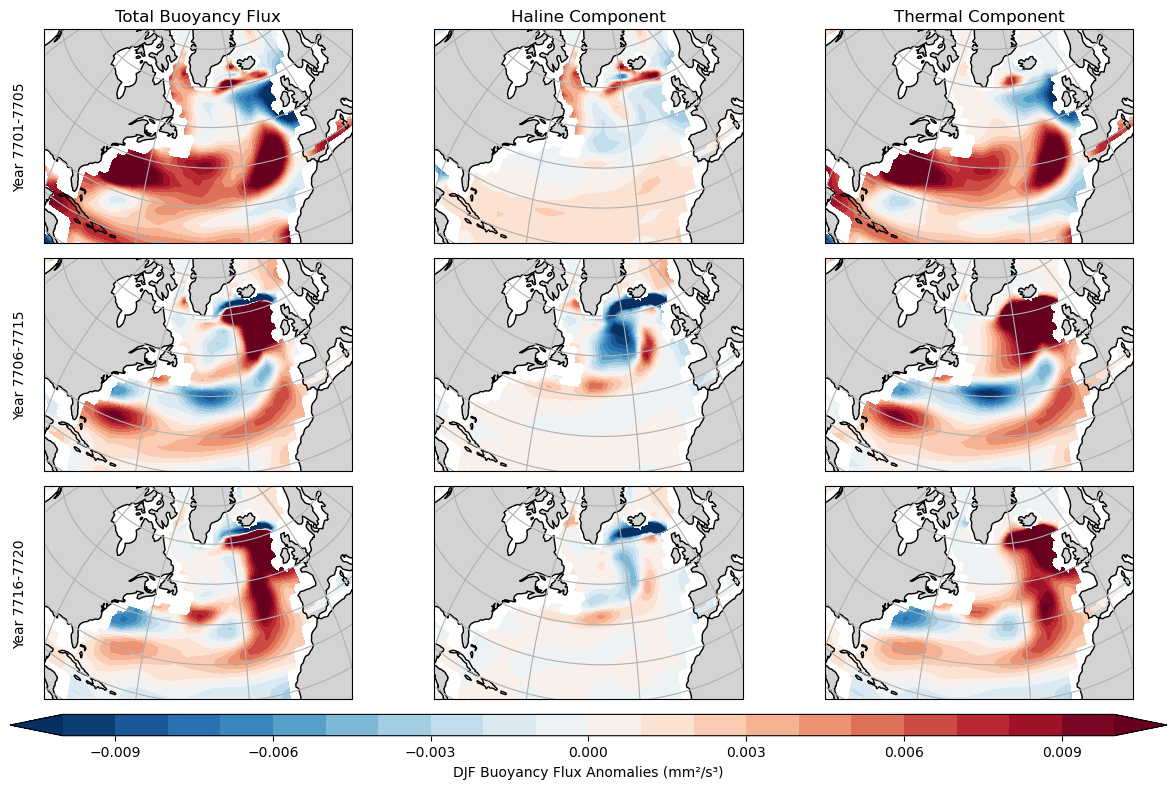

In [27]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 1, 1, 0.1])

titles = ['Total Buoyancy Flux', 'Haline Component', 'Thermal Component']
periods = ['period1', 'period2', 'period3']
years = ['7701-7705', '7706-7715', '7716-7720']
components = ['total', 'haline', 'thermal']

# North Atlantic centered orthographic projection
proj = ccrs.Orthographic(central_longitude=-40, central_latitude=45)

for row, period in enumerate(periods):
    for col, component in enumerate(components):
        ax = plt.subplot(gs[row, col], projection=proj)
        
        #data = buoyancy_fluxes_ensmean[period][component]
        data = (volc_winter_periods_bflux[period][component] - novolc_winter_periods_bflux[period][component])
        im = ax.contourf(data.lon, data.lat, data, 
                        levels=np.linspace(-0.01, 0.01, 21),
                        transform=ccrs.PlateCarree(),
                        extend='both',
                        cmap='RdBu_r')
        
        ax.coastlines()
        ax.add_feature(cfeature.LAND, color='lightgray')
        
        # Set map extent to focus on North Atlantic
        ax.set_extent([-90, 0, 20, 70], ccrs.PlateCarree())
        
        # Add gridlines
        ax.gridlines()
        
        if row == 0:
            ax.set_title(titles[col])
        if col == 0:
            ax.text(-0.1, 0.5, f'Year {years[row]}', 
                   transform=ax.transAxes, rotation=90, 
                   verticalalignment='center')

cbar_ax = plt.subplot(gs[3, :])
plt.colorbar(im, cax=cbar_ax, label='DJF Buoyancy Flux Anomalies (mm²/s³)', 
            orientation='horizontal')
plt.tight_layout()



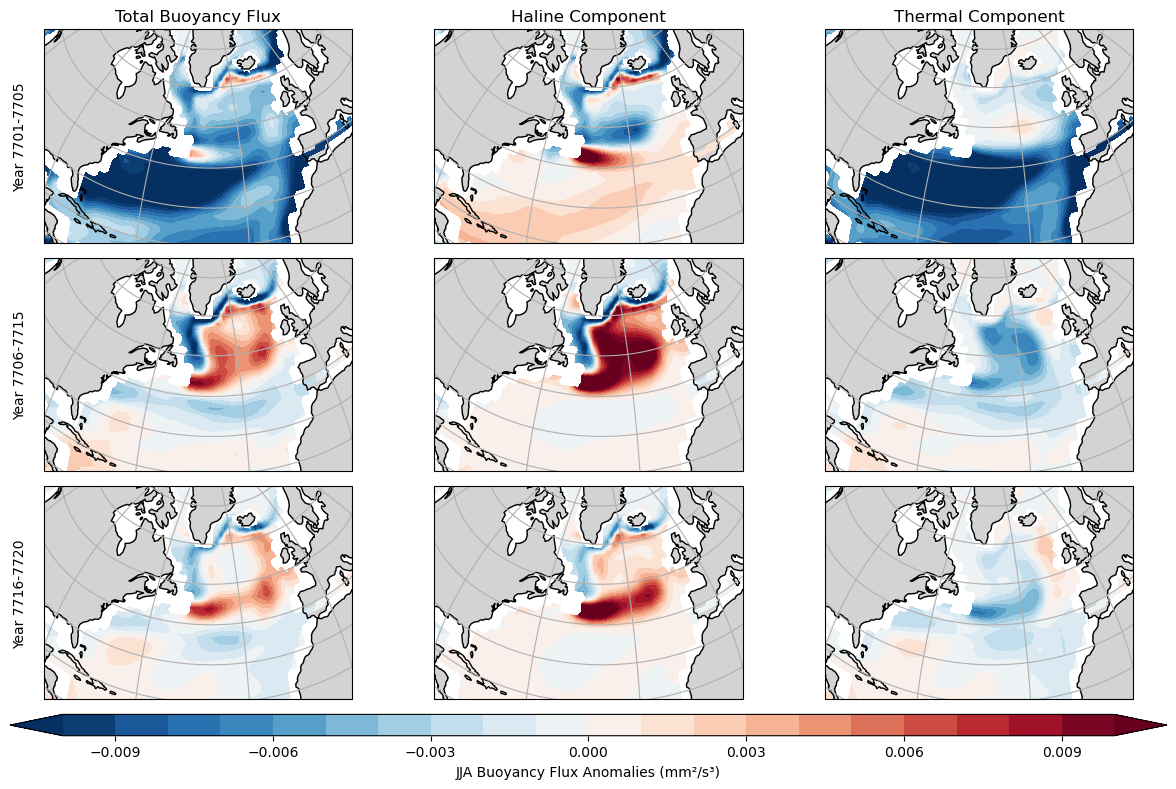

In [28]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 1, 1, 0.1])

titles = ['Total Buoyancy Flux', 'Haline Component', 'Thermal Component']
periods = ['period1', 'period2', 'period3']
years = ['7701-7705', '7706-7715', '7716-7720']
components = ['total', 'haline', 'thermal']

# North Atlantic centered orthographic projection
proj = ccrs.Orthographic(central_longitude=-40, central_latitude=45)

for row, period in enumerate(periods):
    for col, component in enumerate(components):
        ax = plt.subplot(gs[row, col], projection=proj)
        
        #data = buoyancy_fluxes_ensmean[period][component]
        data = (volc_summer_periods_bflux[period][component] - novolc_summer_periods_bflux[period][component])
        im = ax.contourf(data.lon, data.lat, data, 
                        levels=np.linspace(-0.01, 0.01, 21),
                        transform=ccrs.PlateCarree(),
                        extend='both',
                        cmap='RdBu_r')
        
        ax.coastlines()
        ax.add_feature(cfeature.LAND, color='lightgray')
        
        # Set map extent to focus on North Atlantic
        ax.set_extent([-90, 0, 20, 70], ccrs.PlateCarree())
        
        # Add gridlines
        ax.gridlines()
        
        if row == 0:
            ax.set_title(titles[col])
        if col == 0:
            ax.text(-0.1, 0.5, f'Year {years[row]}', 
                   transform=ax.transAxes, rotation=90, 
                   verticalalignment='center')

cbar_ax = plt.subplot(gs[3, :])
plt.colorbar(im, cax=cbar_ax, label='JJA Buoyancy Flux Anomalies (mm²/s³)', 
            orientation='horizontal')
plt.tight_layout()



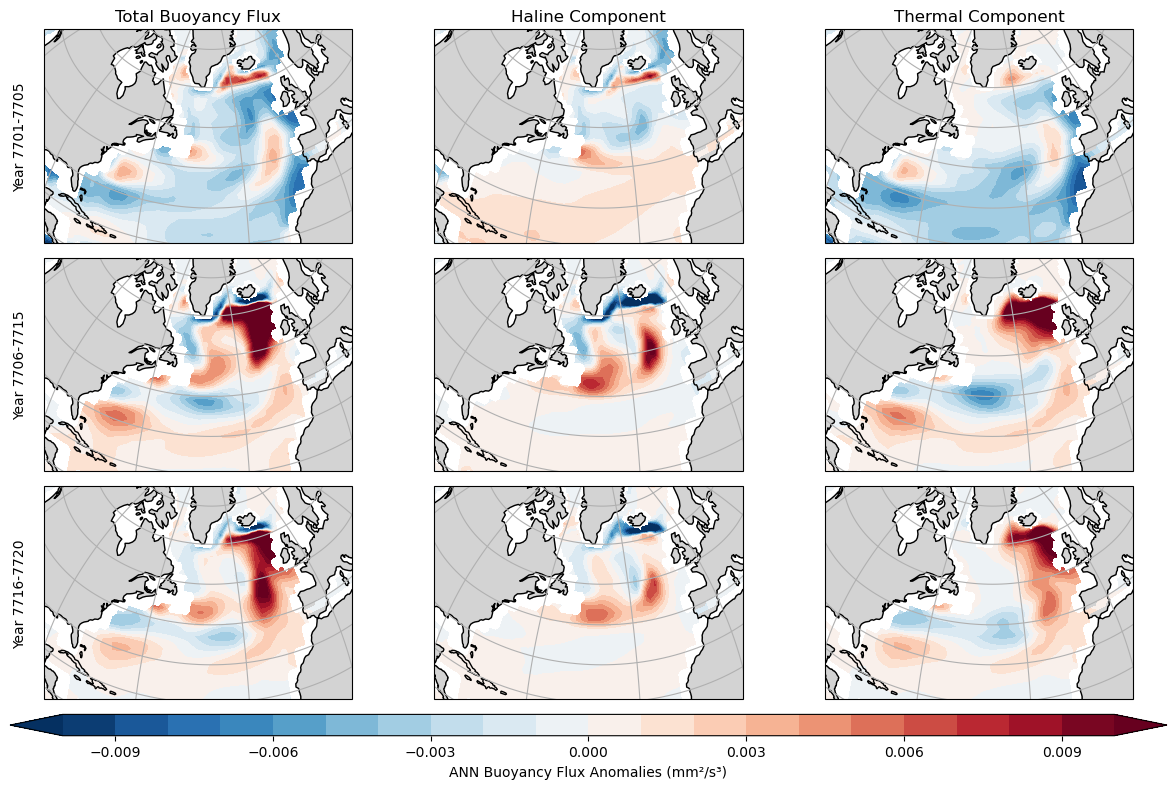

In [29]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(4, 3, height_ratios=[1, 1, 1, 0.1])

titles = ['Total Buoyancy Flux', 'Haline Component', 'Thermal Component']
periods = ['period1', 'period2', 'period3']
years = ['7701-7705', '7706-7715', '7716-7720']
components = ['total', 'haline', 'thermal']

# North Atlantic centered orthographic projection
proj = ccrs.Orthographic(central_longitude=-40, central_latitude=45)

for row, period in enumerate(periods):
    for col, component in enumerate(components):
        ax = plt.subplot(gs[row, col], projection=proj)
        
        #data = buoyancy_fluxes_ensmean[period][component]
        data = (volc_annual_periods_bflux[period][component] - novolc_annual_periods_bflux[period][component])
        im = ax.contourf(data.lon, data.lat, data, 
                        levels=np.linspace(-0.01, 0.01, 21),
                        transform=ccrs.PlateCarree(),
                        extend='both',
                        cmap='RdBu_r')
        
        ax.coastlines()
        ax.add_feature(cfeature.LAND, color='lightgray')
        
        # Set map extent to focus on North Atlantic
        ax.set_extent([-90, 0, 20, 70], ccrs.PlateCarree())
        
        # Add gridlines
        ax.gridlines()
        
        if row == 0:
            ax.set_title(titles[col])
        if col == 0:
            ax.text(-0.1, 0.5, f'Year {years[row]}', 
                   transform=ax.transAxes, rotation=90, 
                   verticalalignment='center')

cbar_ax = plt.subplot(gs[3, :])
plt.colorbar(im, cax=cbar_ax, label='ANN Buoyancy Flux Anomalies (mm²/s³)', 
            orientation='horizontal')
plt.tight_layout()



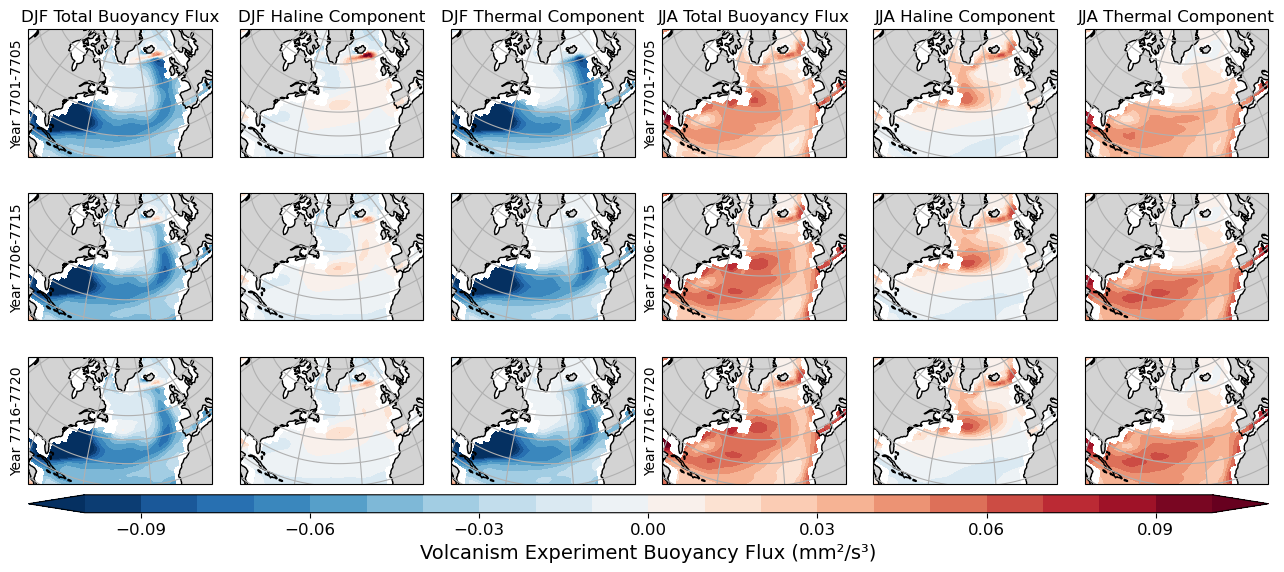

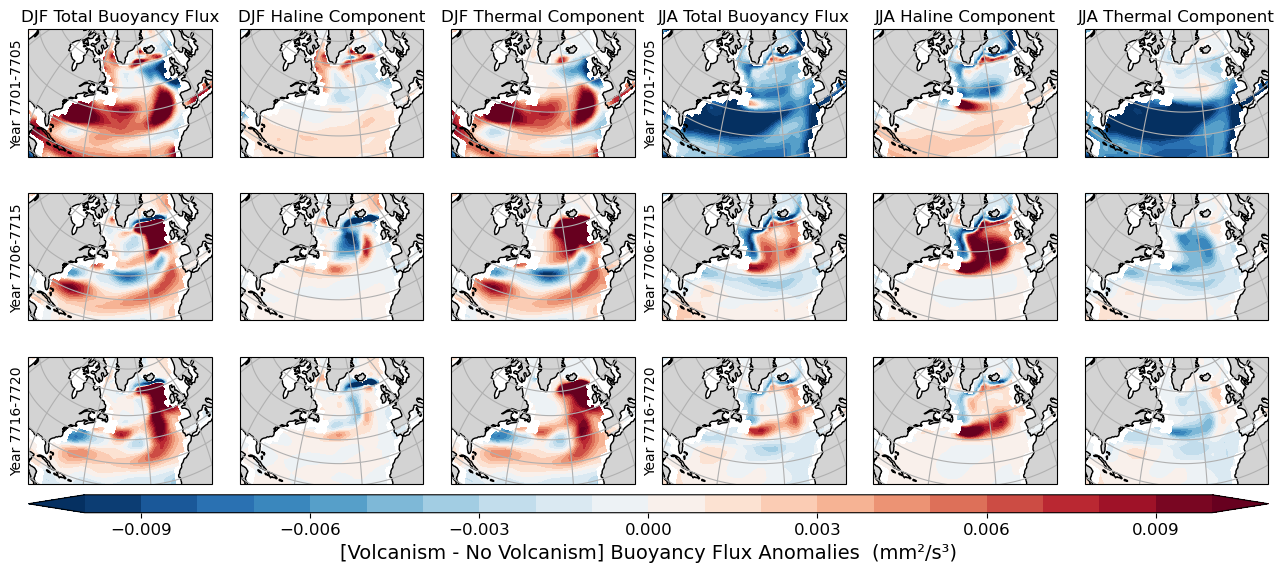

In [30]:
def create_buoyancy_plots(seasons_data, anomaly=False):
    fig = plt.figure(figsize=(16, 13))
    gs = gridspec.GridSpec(7, 6, height_ratios=[1, 1, 1, 0.1, 1, 1, 1])

    titles = ['Total Buoyancy Flux', 'Haline Component', 'Thermal Component'] 
    periods = ['period1', 'period2', 'period3']
    years = ['7701-7705', '7706-7715', '7716-7720']
    components = ['total', 'haline', 'thermal']

    proj = ccrs.Orthographic(central_longitude=-40, central_latitude=45)

    for season_idx, (season_name, season_data) in enumerate(seasons_data.items()):
        offset = 4 if season_idx == 1 else 0  # Offset for second set of plots
        
        for row, period in enumerate(periods):
            for col, component in enumerate(components):
                ax = plt.subplot(gs[row, col + (3 * season_idx)], projection=proj)
                
                if anomaly:
                    data = (season_data['volc'][period][component] - 
                           season_data['novolc'][period][component])
                else:
                    data = season_data['volc'][period][component]
                    
                im = ax.contourf(data.lon, data.lat, data,
                                levels=np.linspace(-0.01, 0.01, 21) if anomaly else np.linspace(-0.1, 0.1, 21),
                                transform=ccrs.PlateCarree(),
                                extend='both',
                                cmap='RdBu_r')
                
                ax.coastlines()
                ax.add_feature(cfeature.LAND, color='lightgray')
                ax.set_extent([-90, 0, 20, 70], ccrs.PlateCarree())
                ax.gridlines()
                
                if row == 0:
                    ax.set_title(f'{season_name} {titles[col]}')
                if col == 0:
                    ax.text(-0.1, 0.5, f'Year {years[row]}',
                           transform=ax.transAxes, rotation=90,
                           verticalalignment='center')

    # Single colorbar at bottom
    cbar_ax = plt.subplot(gs[3, :])
    label = f'{"[Volcanism - No Volcanism] Buoyancy Flux Anomalies " if anomaly else "Volcanism Experiment Buoyancy Flux"} (mm²/s³)'
    cbar = plt.colorbar(im, cax=cbar_ax, label=label, orientation='horizontal')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label, size=14)

    #plt.tight_layout()
    plt.subplots_adjust(wspace=0.15, hspace=-0.1)
    return fig

# Dictionary with seasonal data
seasons_data = {
    'DJF': {'volc': volc_winter_periods_bflux, 'novolc': novolc_winter_periods_bflux},
    'JJA': {'volc': volc_summer_periods_bflux, 'novolc': novolc_summer_periods_bflux}
}

# Create only one plot based on anomaly flag
fig1 = create_buoyancy_plots(seasons_data, anomaly=False)
fig2 = create_buoyancy_plots(seasons_data, anomaly=True)


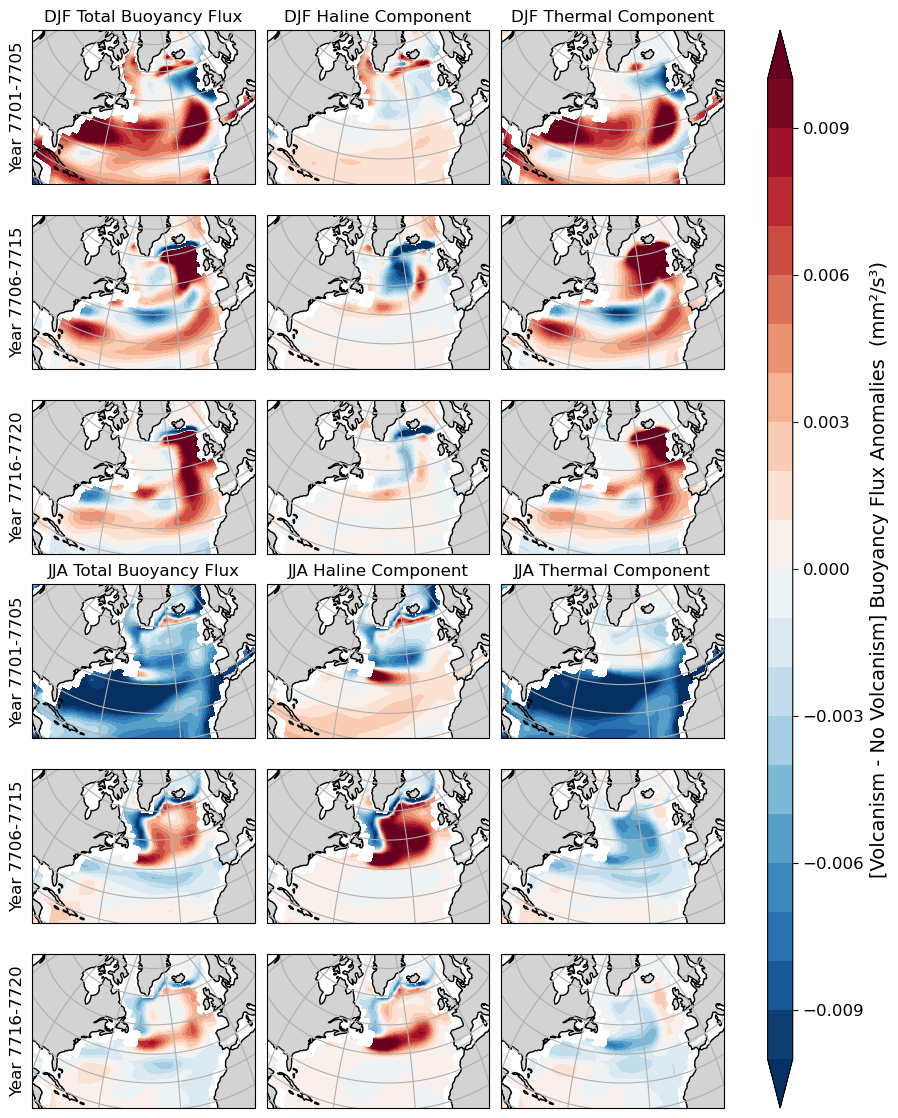

In [31]:
def create_buoyancy_plots(seasons_data, anomaly=False):
    fig = plt.figure(figsize=(10, 14))
    gs = gridspec.GridSpec(6, 5, width_ratios=[1, 1, 1, 0.25, 0.1], height_ratios=[1, 1, 1, 1, 1, 1])

    titles = ['Total Buoyancy Flux', 'Haline Component', 'Thermal Component']
    periods = ['period1', 'period2', 'period3']
    years = ['7701-7705', '7706-7715', '7716-7720']
    components = ['total', 'haline', 'thermal']

    proj = ccrs.Orthographic(central_longitude=-40, central_latitude=45)

    for season_idx, (season_name, season_data) in enumerate(seasons_data.items()):
        row_offset = 3 if season_name == 'JJA' else 0  # Summer plots start at row 3
        
        for row, period in enumerate(periods):
            for col, component in enumerate(components):
                ax = plt.subplot(gs[row + row_offset, col], projection=proj)
                
                if anomaly:
                    data = (season_data['volc'][period][component] - 
                           season_data['novolc'][period][component])
                else:
                    data = season_data['volc'][period][component]
                    
                im = ax.contourf(data.lon, data.lat, data,
                                levels=np.linspace(-0.01, 0.01, 21) if anomaly else np.linspace(-0.1, 0.1, 21),
                                transform=ccrs.PlateCarree(),
                                extend='both',
                                cmap='RdBu_r')
                
                ax.coastlines()
                ax.add_feature(cfeature.LAND, color='lightgray')
                ax.set_extent([-90, 0, 20, 70], ccrs.PlateCarree())
                ax.gridlines()
                
                if row == 0:
                    ax.set_title(f'{season_name} {titles[col]}')
                if col == 0:
                    ax.text(-0.1, 0.5, f'Year {years[row]}',
                           transform=ax.transAxes, rotation=90,
                           verticalalignment='center', size=12)

    # Single colorbar on right side that spans all plots
    cbar_ax = plt.subplot(gs[:, -1])
    label = f'{"[Volcanism - No Volcanism] Buoyancy Flux Anomalies " if anomaly else "Volcanism Experiment Buoyancy Flux"} (mm²/s³)'
    cbar = plt.colorbar(im, cax=cbar_ax, label=label, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label, size=14)

    #plt.tight_layout()
    plt.subplots_adjust(wspace=-0.1, hspace=0.2)
    return fig

# Dictionary with seasonal data
seasons_data = {
    'DJF': {'volc': volc_winter_periods_bflux, 'novolc': novolc_winter_periods_bflux},
    'JJA': {'volc': volc_summer_periods_bflux, 'novolc': novolc_summer_periods_bflux}
}

# Create only one plot based on anomaly flag 
fig = create_buoyancy_plots(seasons_data, anomaly=True)
#plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2, wspace=0.2, hspace=0.2)
icepaperdir = "/home/guido/Dropbox/plots/volcanic/"
saveplot = False
if saveplot:
    plt.savefig(icepaperdir+"Figure3a_GRL.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    plt.savefig(icepaperdir+"Figure3a_GRL.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)


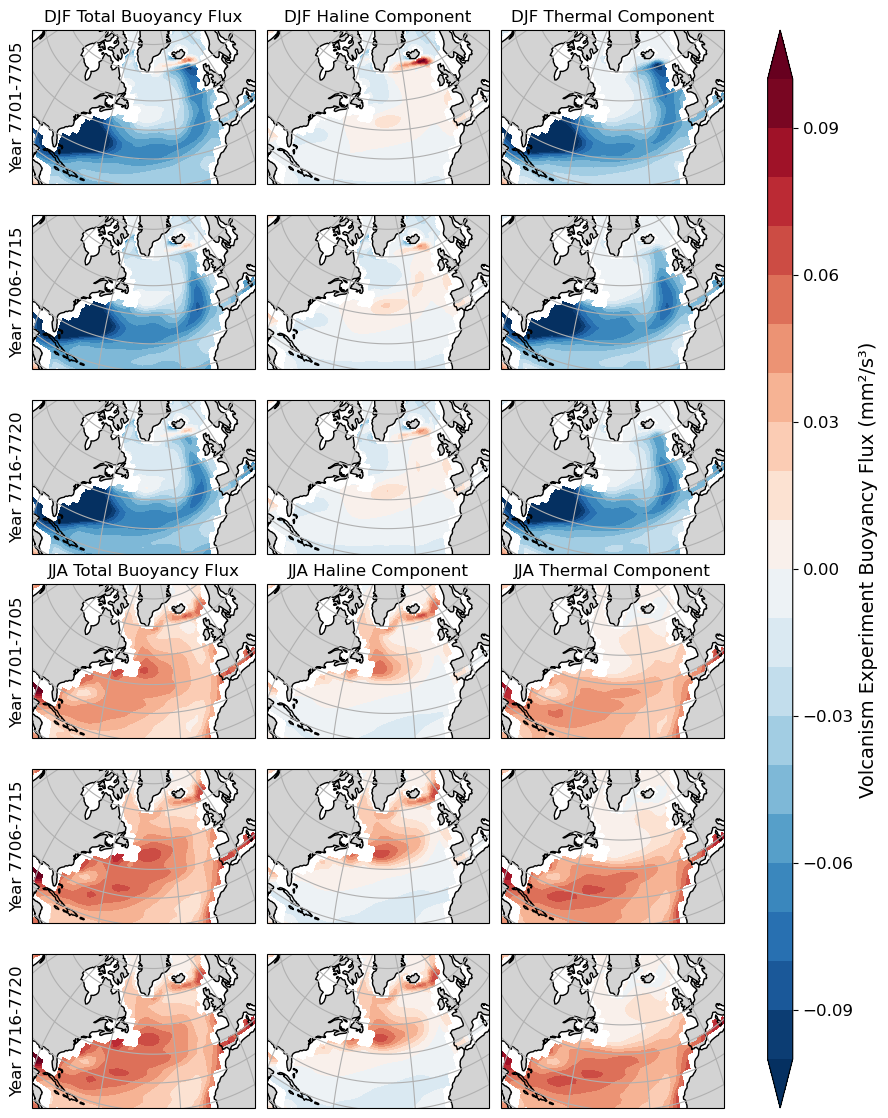

In [32]:
def create_buoyancy_plots(seasons_data, anomaly=False):
    fig = plt.figure(figsize=(10, 14))
    gs = gridspec.GridSpec(6, 5, width_ratios=[1, 1, 1, 0.25, 0.1], height_ratios=[1, 1, 1, 1, 1, 1])

    titles = ['Total Buoyancy Flux', 'Haline Component', 'Thermal Component']
    periods = ['period1', 'period2', 'period3']
    years = ['7701-7705', '7706-7715', '7716-7720']
    components = ['total', 'haline', 'thermal']

    proj = ccrs.Orthographic(central_longitude=-40, central_latitude=45)

    for season_idx, (season_name, season_data) in enumerate(seasons_data.items()):
        row_offset = 3 if season_name == 'JJA' else 0  # Summer plots start at row 3
        
        for row, period in enumerate(periods):
            for col, component in enumerate(components):
                ax = plt.subplot(gs[row + row_offset, col], projection=proj)
                
                if anomaly:
                    data = (season_data['volc'][period][component] - 
                           season_data['novolc'][period][component])
                else:
                    data = season_data['volc'][period][component]
                    
                im = ax.contourf(data.lon, data.lat, data,
                                levels=np.linspace(-0.01, 0.01, 21) if anomaly else np.linspace(-0.1, 0.1, 21),
                                transform=ccrs.PlateCarree(),
                                extend='both',
                                cmap='RdBu_r')
                
                ax.coastlines()
                ax.add_feature(cfeature.LAND, color='lightgray')
                ax.set_extent([-90, 0, 20, 70], ccrs.PlateCarree())
                ax.gridlines()
                
                if row == 0:
                    ax.set_title(f'{season_name} {titles[col]}')
                if col == 0:
                    ax.text(-0.1, 0.5, f'Year {years[row]}',
                           transform=ax.transAxes, rotation=90,
                           verticalalignment='center', size=12)

    # Single colorbar on right side that spans all plots
    cbar_ax = plt.subplot(gs[:, -1])
    label = f'{"[Volcanism - No Volcanism] Buoyancy Flux Anomalies " if anomaly else "Volcanism Experiment Buoyancy Flux"} (mm²/s³)'
    cbar = plt.colorbar(im, cax=cbar_ax, label=label, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label, size=14)

    #plt.tight_layout()
    plt.subplots_adjust(wspace=-0.1, hspace=0.2)
    return fig

# Dictionary with seasonal data
seasons_data = {
    'DJF': {'volc': volc_winter_periods_bflux, 'novolc': novolc_winter_periods_bflux},
    'JJA': {'volc': volc_summer_periods_bflux, 'novolc': novolc_summer_periods_bflux}
}

# Create only one plot based on anomaly flag 
fig = create_buoyancy_plots(seasons_data, anomaly=False)
#plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2, wspace=0.2, hspace=0.2)
icepaperdir = "/home/guido/Dropbox/plots/volcanic/"
saveplot = False
if saveplot:
    plt.savefig(icepaperdir+"FigureSbflux_GRL.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    plt.savefig(icepaperdir+"FigureSbflux_GRL.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)


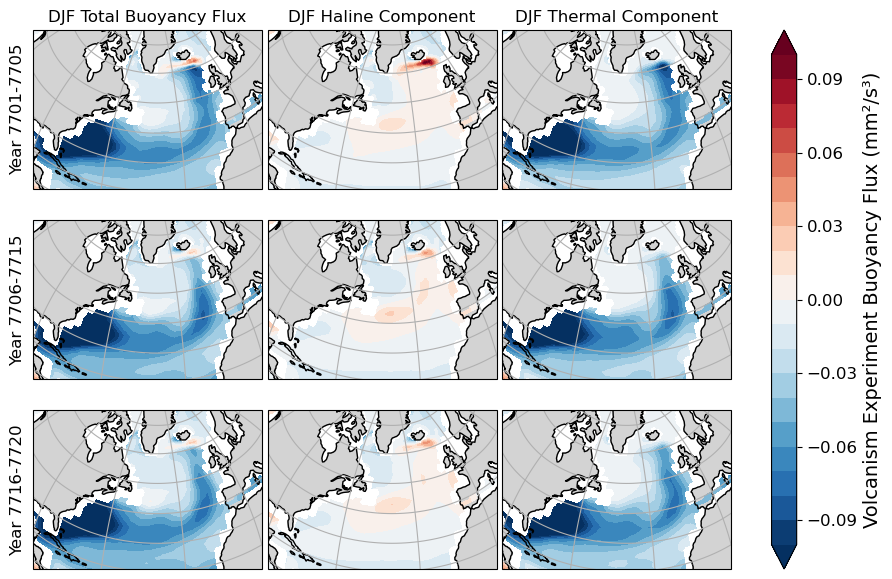

In [33]:
def create_buoyancy_plots(seasons_data, anomaly=False):
    fig = plt.figure(figsize=(10, 7))
    gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 1, 0.25, 0.1], height_ratios=[1, 1, 1])

    titles = ['Total Buoyancy Flux', 'Haline Component', 'Thermal Component']
    periods = ['period1', 'period2', 'period3']
    years = ['7701-7705', '7706-7715', '7716-7720']
    components = ['total', 'haline', 'thermal']

    proj = ccrs.Orthographic(central_longitude=-40, central_latitude=45)

    season_name = 'DJF'
    season_data = seasons_data[season_name]
        
    for row, period in enumerate(periods):
        for col, component in enumerate(components):
            ax = plt.subplot(gs[row, col], projection=proj)
            
            if anomaly:
                data = (season_data['volc'][period][component] - 
                       season_data['novolc'][period][component])
            else:
                data = season_data['volc'][period][component]
                
            im = ax.contourf(data.lon, data.lat, data,
                            levels=np.linspace(-0.01, 0.01, 21) if anomaly else np.linspace(-0.1, 0.1, 21),
                            transform=ccrs.PlateCarree(),
                            extend='both',
                            cmap='RdBu_r')
            
            ax.coastlines()
            ax.add_feature(cfeature.LAND, color='lightgray')
            ax.set_extent([-90, 0, 20, 70], ccrs.PlateCarree())
            ax.gridlines()
            
            if row == 0:
                ax.set_title(f'{season_name} {titles[col]}')
            if col == 0:
                ax.text(-0.1, 0.5, f'Year {years[row]}',
                       transform=ax.transAxes, rotation=90,
                       verticalalignment='center', size=12)

    # Single colorbar on right side that spans all plots
    cbar_ax = plt.subplot(gs[:, -1])
    label = f'{"[Volcanism - No Volcanism] Buoyancy Flux Anomalies " if anomaly else "Volcanism Experiment Buoyancy Flux"} (mm²/s³)'
    cbar = plt.colorbar(im, cax=cbar_ax, label=label, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label, size=14)

    plt.subplots_adjust(wspace=-0.1, hspace=0.2)
    return fig

# Dictionary with seasonal data
seasons_data = {
    'DJF': {'volc': volc_winter_periods_bflux, 'novolc': novolc_winter_periods_bflux},
    'JJA': {'volc': volc_summer_periods_bflux, 'novolc': novolc_summer_periods_bflux}
}

# Create only one plot based on anomaly flag 
fig = create_buoyancy_plots(seasons_data, anomaly=False)
icepaperdir = "/home/guido/Dropbox/plots/volcanic/"
saveplot = False
if saveplot:
    plt.savefig(icepaperdir+"FigureSbflux_GRL_DJF.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    plt.savefig(icepaperdir+"FigureSbflux_GRL_DJF.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

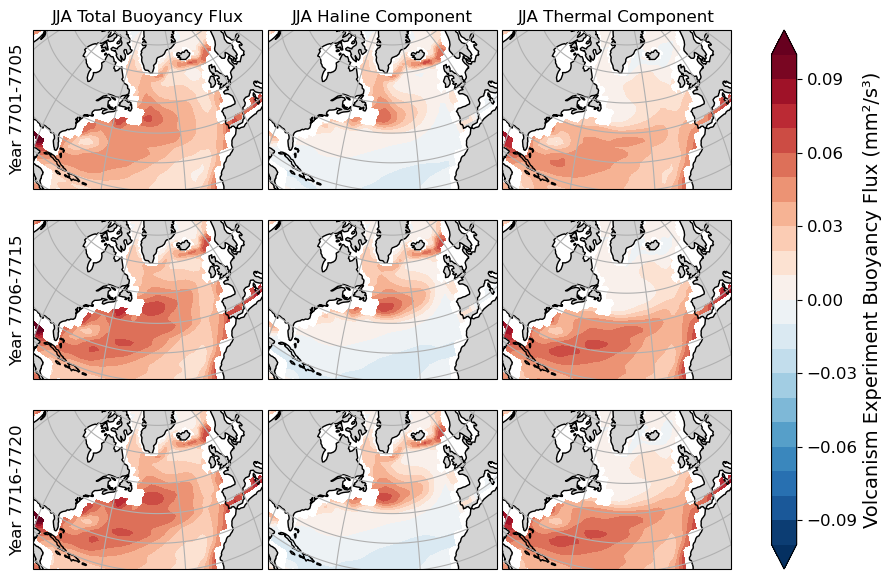

In [34]:
def create_buoyancy_plots(seasons_data, anomaly=False):
    fig = plt.figure(figsize=(10, 7))
    gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 1, 0.25, 0.1], height_ratios=[1, 1, 1])

    titles = ['Total Buoyancy Flux', 'Haline Component', 'Thermal Component']
    periods = ['period1', 'period2', 'period3']
    years = ['7701-7705', '7706-7715', '7716-7720']
    components = ['total', 'haline', 'thermal']

    proj = ccrs.Orthographic(central_longitude=-40, central_latitude=45)

    season_name = 'JJA'
    season_data = seasons_data[season_name]
        
    for row, period in enumerate(periods):
        for col, component in enumerate(components):
            ax = plt.subplot(gs[row, col], projection=proj)
            
            if anomaly:
                data = (season_data['volc'][period][component] - 
                       season_data['novolc'][period][component])
            else:
                data = season_data['volc'][period][component]
                
            im = ax.contourf(data.lon, data.lat, data,
                            levels=np.linspace(-0.01, 0.01, 21) if anomaly else np.linspace(-0.1, 0.1, 21),
                            transform=ccrs.PlateCarree(),
                            extend='both',
                            cmap='RdBu_r')
            
            ax.coastlines()
            ax.add_feature(cfeature.LAND, color='lightgray')
            ax.set_extent([-90, 0, 20, 70], ccrs.PlateCarree())
            ax.gridlines()
            
            if row == 0:
                ax.set_title(f'{season_name} {titles[col]}')
            if col == 0:
                ax.text(-0.1, 0.5, f'Year {years[row]}',
                       transform=ax.transAxes, rotation=90,
                       verticalalignment='center', size=12)

    # Single colorbar on right side that spans all plots
    cbar_ax = plt.subplot(gs[:, -1])
    label = f'{"[Volcanism - No Volcanism] Buoyancy Flux Anomalies " if anomaly else "Volcanism Experiment Buoyancy Flux"} (mm²/s³)'
    cbar = plt.colorbar(im, cax=cbar_ax, label=label, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label, size=14)

    plt.subplots_adjust(wspace=-0.1, hspace=0.2)
    return fig

# Dictionary with seasonal data
seasons_data = {
    'DJF': {'volc': volc_winter_periods_bflux, 'novolc': novolc_winter_periods_bflux},
    'JJA': {'volc': volc_summer_periods_bflux, 'novolc': novolc_summer_periods_bflux}
}

# Create only one plot based on anomaly flag 
fig = create_buoyancy_plots(seasons_data, anomaly=False)
icepaperdir = "/home/guido/Dropbox/plots/volcanic/"
saveplot = False
if saveplot:
    plt.savefig(icepaperdir+"FigureSbflux_GRL_JJA.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    plt.savefig(icepaperdir+"FigureSbflux_GRL_JJA.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

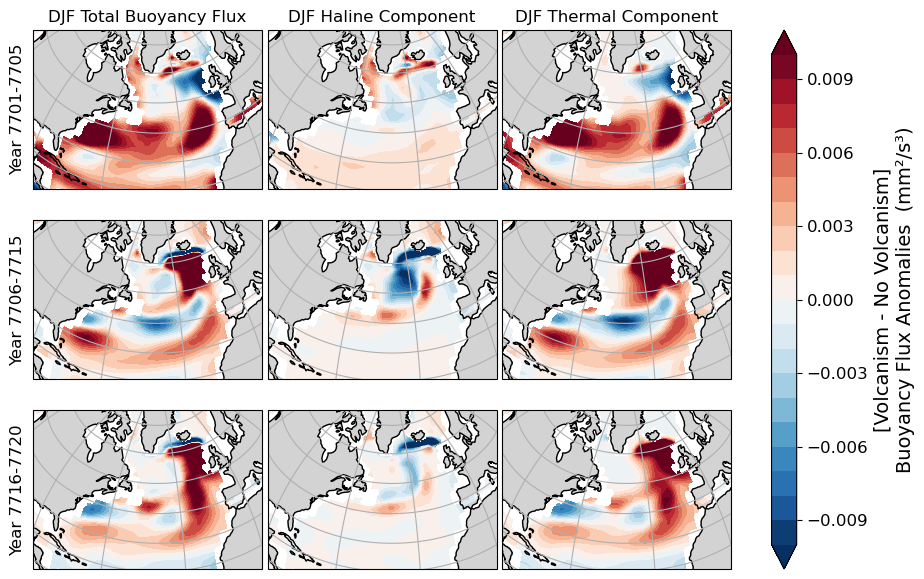

In [35]:
def create_buoyancy_plots(seasons_data, anomaly=False):
    fig = plt.figure(figsize=(10, 7))
    gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 1, 0.25, 0.1], height_ratios=[1, 1, 1])

    titles = ['Total Buoyancy Flux', 'Haline Component', 'Thermal Component']
    periods = ['period1', 'period2', 'period3']
    years = ['7701-7705', '7706-7715', '7716-7720']
    components = ['total', 'haline', 'thermal']

    proj = ccrs.Orthographic(central_longitude=-40, central_latitude=45)

    season_name = 'DJF'
    season_data = seasons_data[season_name]
        
    for row, period in enumerate(periods):
        for col, component in enumerate(components):
            ax = plt.subplot(gs[row, col], projection=proj)
            
            if anomaly:
                data = (season_data['volc'][period][component] - 
                       season_data['novolc'][period][component])
            else:
                data = season_data['volc'][period][component]
                
            im = ax.contourf(data.lon, data.lat, data,
                            levels=np.linspace(-0.01, 0.01, 21) if anomaly else np.linspace(-0.1, 0.1, 21),
                            transform=ccrs.PlateCarree(),
                            extend='both',
                            cmap='RdBu_r')
            
            ax.coastlines()
            ax.add_feature(cfeature.LAND, color='lightgray')
            ax.set_extent([-90, 0, 20, 70], ccrs.PlateCarree())
            ax.gridlines()
            
            if row == 0:
                ax.set_title(f'{season_name} {titles[col]}')
            if col == 0:
                ax.text(-0.1, 0.5, f'Year {years[row]}',
                       transform=ax.transAxes, rotation=90,
                       verticalalignment='center', size=12)

    # Single colorbar on right side that spans all plots
    cbar_ax = plt.subplot(gs[:, -1])
    label = f'{"[Volcanism - No Volcanism]\nBuoyancy Flux Anomalies " if anomaly else "Volcanism Experiment Buoyancy Flux"} (mm²/s³)'
    cbar = plt.colorbar(im, cax=cbar_ax, label=label, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label, size=14)

    plt.subplots_adjust(wspace=-0.1, hspace=0.2)
    return fig

# Dictionary with seasonal data
seasons_data = {
    'DJF': {'volc': volc_winter_periods_bflux, 'novolc': novolc_winter_periods_bflux},
    'JJA': {'volc': volc_summer_periods_bflux, 'novolc': novolc_summer_periods_bflux}
}

# Create only one plot based on anomaly flag 
fig = create_buoyancy_plots(seasons_data, anomaly=True)
icepaperdir = "/home/guido/Dropbox/plots/volcanic/"
saveplot = False
if saveplot:
    plt.savefig(icepaperdir+"Figure3a_GRL_DJF.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    plt.savefig(icepaperdir+"Figure3a_GRL_DJF.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)

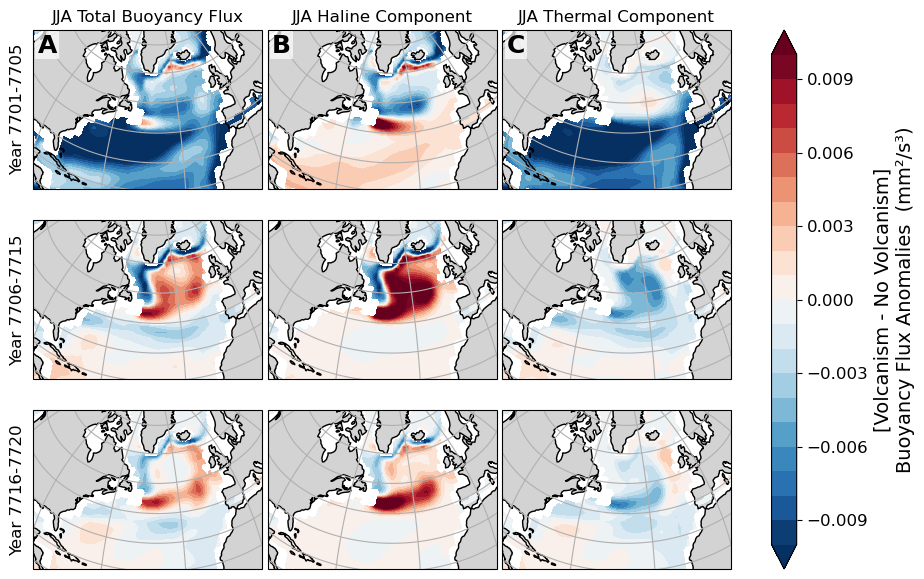

In [39]:
def create_buoyancy_plots(seasons_data, anomaly=False):
    fig = plt.figure(figsize=(10, 7))
    gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 1, 0.25, 0.1], height_ratios=[1, 1, 1])

    titles = ['Total Buoyancy Flux', 'Haline Component', 'Thermal Component']
    periods = ['period1', 'period2', 'period3']
    years = ['7701-7705', '7706-7715', '7716-7720']
    components = ['total', 'haline', 'thermal']
    labels = ['A', 'B', 'C']

    proj = ccrs.Orthographic(central_longitude=-40, central_latitude=45)

    season_name = 'JJA'
    season_data = seasons_data[season_name]
        
    for row, period in enumerate(periods):
        for col, component in enumerate(components):
            ax = plt.subplot(gs[row, col], projection=proj)
            
            if anomaly:
                data = (season_data['volc'][period][component] - 
                       season_data['novolc'][period][component])
            else:
                data = season_data['volc'][period][component]
                
            im = ax.contourf(data.lon, data.lat, data,
                            levels=np.linspace(-0.01, 0.01, 21) if anomaly else np.linspace(-0.1, 0.1, 21),
                            transform=ccrs.PlateCarree(),
                            extend='both',
                            cmap='RdBu_r')
            
            ax.coastlines()
            ax.add_feature(cfeature.LAND, color='lightgray')
            ax.set_extent([-90, 0, 20, 70], ccrs.PlateCarree())
            ax.gridlines()
            
            if row == 0:
                ax.set_title(f'{season_name} {titles[col]}')
                ax.text(0.02, 0.98, labels[col], transform=ax.transAxes,
                       fontsize=18, fontweight='bold', va='top',
                       bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1.5))
            if col == 0:
                ax.text(-0.1, 0.5, f'Year {years[row]}',
                       transform=ax.transAxes, rotation=90,
                       verticalalignment='center', size=12)

    # Single colorbar on right side that spans all plots
    cbar_ax = plt.subplot(gs[:, -1])
    label = f'{"[Volcanism - No Volcanism]\nBuoyancy Flux Anomalies " if anomaly else "Volcanism Experiment Buoyancy Flux"} (mm²/s³)'
    cbar = plt.colorbar(im, cax=cbar_ax, label=label, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label, size=14)

    plt.subplots_adjust(wspace=-0.1, hspace=0.2)
    return fig

# Dictionary with seasonal data
seasons_data = {
    'DJF': {'volc': volc_winter_periods_bflux, 'novolc': novolc_winter_periods_bflux},
    'JJA': {'volc': volc_summer_periods_bflux, 'novolc': novolc_summer_periods_bflux}
}

# Create only one plot based on anomaly flag 
fig = create_buoyancy_plots(seasons_data, anomaly=True)
icepaperdir = "/home/guido/Dropbox/plots/volcanic/"
saveplot = False
if saveplot:
    plt.savefig(icepaperdir+"Figure5_SA.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    plt.savefig(icepaperdir+"Figure5_SA.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)   

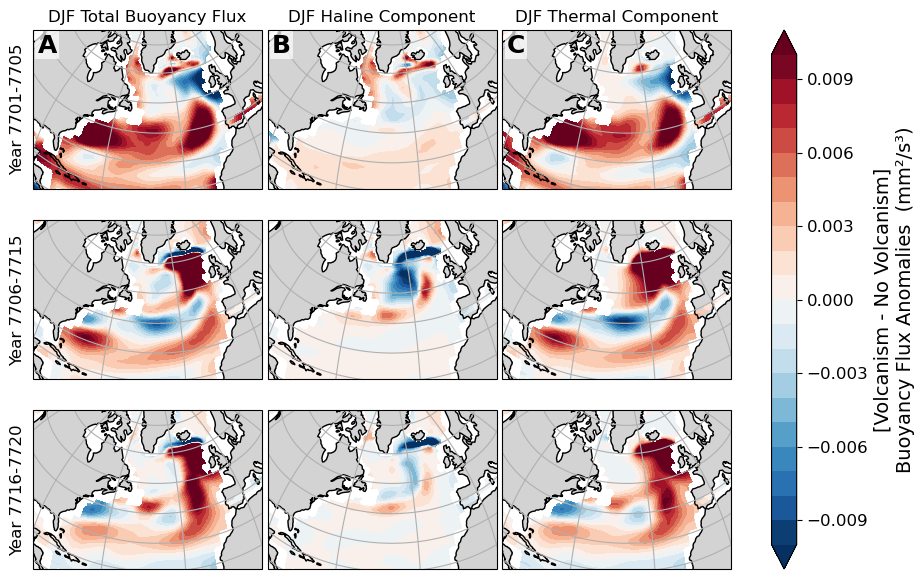

In [38]:
def create_buoyancy_plots(seasons_data, anomaly=False):
    fig = plt.figure(figsize=(10, 7))
    gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 1, 0.25, 0.1], height_ratios=[1, 1, 1])

    titles = ['Total Buoyancy Flux', 'Haline Component', 'Thermal Component']
    periods = ['period1', 'period2', 'period3']
    years = ['7701-7705', '7706-7715', '7716-7720']
    components = ['total', 'haline', 'thermal']
    labels = ['A', 'B', 'C']

    proj = ccrs.Orthographic(central_longitude=-40, central_latitude=45)

    season_name = 'DJF'
    season_data = seasons_data[season_name]
        
    for row, period in enumerate(periods):
        for col, component in enumerate(components):
            ax = plt.subplot(gs[row, col], projection=proj)
            
            if anomaly:
                data = (season_data['volc'][period][component] - 
                       season_data['novolc'][period][component])
            else:
                data = season_data['volc'][period][component]
                
            im = ax.contourf(data.lon, data.lat, data,
                            levels=np.linspace(-0.01, 0.01, 21) if anomaly else np.linspace(-0.1, 0.1, 21),
                            transform=ccrs.PlateCarree(),
                            extend='both',
                            cmap='RdBu_r')
            
            ax.coastlines()
            ax.add_feature(cfeature.LAND, color='lightgray')
            ax.set_extent([-90, 0, 20, 70], ccrs.PlateCarree())
            ax.gridlines()
            
            if row == 0:
                ax.set_title(f'{season_name} {titles[col]}')
                ax.text(0.02, 0.98, labels[col], transform=ax.transAxes,
                       fontsize=18, fontweight='bold', va='top',
                       bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1.5))
            if col == 0:
                ax.text(-0.1, 0.5, f'Year {years[row]}',
                       transform=ax.transAxes, rotation=90,
                       verticalalignment='center', size=12)

    # Single colorbar on right side that spans all plots
    cbar_ax = plt.subplot(gs[:, -1])
    label = f'{"[Volcanism - No Volcanism]\nBuoyancy Flux Anomalies " if anomaly else "Volcanism Experiment Buoyancy Flux"} (mm²/s³)'
    cbar = plt.colorbar(im, cax=cbar_ax, label=label, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label, size=14)

    plt.subplots_adjust(wspace=-0.1, hspace=0.2)
    return fig

# Dictionary with seasonal data
seasons_data = {
    'DJF': {'volc': volc_winter_periods_bflux, 'novolc': novolc_winter_periods_bflux},
    'JJA': {'volc': volc_summer_periods_bflux, 'novolc': novolc_summer_periods_bflux}
}

# Create only one plot based on anomaly flag 
fig = create_buoyancy_plots(seasons_data, anomaly=True)
icepaperdir = "/home/guido/Dropbox/plots/volcanic/"
saveplot = False
if saveplot:
    plt.savefig(icepaperdir+"Figure4_SA.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)
    plt.savefig(icepaperdir+"Figure4_SA.pdf", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=False)